# Randomized measurements

This tutorial shows the different randomized measurements of the `povm_toolbox`.

In [1]:
%load_ext autoreload
%autoreload 2

## Circuit and Observables

We first look at a random the 2-qubit circuit, with depth 3.

In [2]:
from qiskit.circuit.random import random_circuit

num_qubits = 2
qc_random = random_circuit(num_qubits=num_qubits, depth=3, measure=False, seed=0)

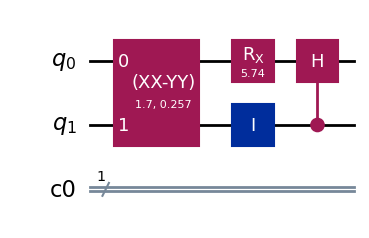

In [3]:
from qiskit.circuit import ClassicalRegister

creg = ClassicalRegister(1)
qc_random.add_register(creg)
qc_random.draw("mpl", style="iqp")

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

# Use AerSimulator as backend.
backend = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Transpile the circuit to an "Instruction Set Architecture" (ISA) circuit
qc_random_isa = pm.run(qc_random)

We also draw 3 random observables.

In [5]:
from qiskit.quantum_info import SparsePauliOp

set_observables = [
    SparsePauliOp(["II", "XX", "YY", "ZY"], coeffs=[1, 1, -4, 1]),
    SparsePauliOp(["XI", "ZX", "YI"], coeffs=[1, -1, 2.5]),
    SparsePauliOp(["II", "XI", "ZI", "IX", "IY", "YX"], coeffs=[0.4, 4, -1, 1, -0.5, 1.8]),
]

For reference, we compute the true final state and the exact expectation values for the different observables.

In [6]:
import numpy as np
from qiskit.quantum_info import Statevector

exact_state = Statevector(qc_random)
exp_val = np.real_if_close(
    np.array([exact_state.expectation_value(obs) for obs in set_observables])
)

## Classical Shadows

We now look at the implementation of Classical Shadows measurement.

In [7]:
from povm_toolbox.library import ClassicalShadows

# By default, the Classical Shadows (CS) measurement uses X,Y,Z measurements with equal probability.
cs_implementation = ClassicalShadows(num_qubits=num_qubits, seed=23)
# Define the default shot budget.
cs_shots = 4096
# Construct the `POVMSamplerPub`.
cs_pub = (qc_random_isa, None, cs_shots, cs_implementation)

## Locally-Biased Classical Shadows
We now look at Classical Shadows that can be locally-biased.

In [8]:
from povm_toolbox.library import LocallyBiasedClassicalShadows

# Set the distributions of the shots among the X,Y,Z measurements.
bias = np.array(
    [
        [0.0000000028, 0.4408677642, 0.5591322330],  # bias for first qubit
        [0.1989721524, 0.3190601952, 0.4819676524],  # bias for second qubit
    ]
)

# The Locally-Biased Classical Shadows (LBCS) measurement uses X,Y,Z measurements with different probabilities.
lbcs_implementation = LocallyBiasedClassicalShadows(num_qubits=num_qubits, bias=bias, seed=24)
# Define the default shot budget.
lbcs_shots = 4096
# Construct the `POVMSamplerPub`.
lbcs_pub = (qc_random_isa, None, lbcs_shots, lbcs_implementation)

## Mutually-Unbiased-Bases POVM
We now look at POVMs that are rotated locally-biased Classical Shadows.

In [9]:
from povm_toolbox.library import MutuallyUnbiasedBasesMeasurements

# Define the Euler angles to rotate the measurement.
angles = np.array(
    [
        [0.0000027222, 0.0000000910, 0.3],
        [0.0000022917, 0.0000002655, 0.0],
    ]
)

# Set the distributions of the shots among the PMs.
bias = np.array(
    [
        [0.0000372719, 0.4377084332, 0.5622542949],
        [0.2002136793, 0.3192036469, 0.4805826738],
    ]
)

# Define the PM-simulable POVM.
mub_implementation = MutuallyUnbiasedBasesMeasurements(
    num_qubits=num_qubits, bias=bias, angles=angles, seed=12
)
# Define the default shot budget.
mub_shots = 4100
# Construct the `POVMSamplerPub`.
mub_pub = (qc_random_isa, None, mub_shots, mub_implementation)

## PM-simulable POVM
We now look at POVMs that are simulable (through randomization) with only single-qubit projective measurements (PMs).

In [10]:
from povm_toolbox.library import RandomizedProjectiveMeasurements

# Define our projective measurements acting on each qubit.
angles = np.array(
    [
        [0.0000027222, 0.0000000910, 1.5707688831, 0.0000235665, 1.5707519773, 1.5707694998],
        [0.0000022917, 0.0000002655, 1.5707961328, 0.0000069500, 1.5707958682, 1.5708006931],
    ]
)

# Set the distributions of the shots among the PMs.
bias = np.array(
    [
        [0.0000372719, 0.4377084332, 0.5622542949],
        [0.2002136793, 0.3192036469, 0.4805826738],
    ]
)

# Define the PM-simulable POVM.
pmsim_implementation = RandomizedProjectiveMeasurements(
    num_qubits=num_qubits, bias=bias, angles=angles, seed=25
)
# Define the default shot budget.
pmsim_shots = 4100
# Construct the `POVMSamplerPub`.
pmsim_pub = (qc_random_isa, None, pmsim_shots, pmsim_implementation)

## POVM Sampler

We now instantiate the `POVMSampler` that will use the different POVM measurements.

In [11]:
from povm_toolbox.sampler.povm_sampler import POVMSampler
from qiskit_aer.primitives import SamplerV2 as AerSampler

# First define a standard sampler (that will be used under the hood).
aer_sampler = AerSampler(seed=26)
# Then define the POVM sampler, which takes BaseSampler as an argument.
povm_sampler = POVMSampler(aer_sampler)
# Submit the job by specifying which POVM to use, which circuit(s) to measure and the shot budget.
job = povm_sampler.run([cs_pub, lbcs_pub, mub_pub, pmsim_pub])

### Results
We retrieve the result object, which contains the POVM used and from which we can query the counts of each outcome.

In [12]:
from povm_toolbox.post_processor.povm_post_processor import POVMPostProcessor

# Retrieve the `PrimitiveResult` object, which contains 3 `POVMPubResult` objects.
result = job.result()
print(f'\n{"-":-<85}-\n')

# Loop through the different PUB results
for k, pub_result in enumerate(result):
    # Instantiate the post-processor from the PUB result.
    post_processor = POVMPostProcessor(pub_result)
    print(f"PUB number : {k}")
    # If one wants to explicitly retrieve the POVM used for a specific PUB,
    # it can be accessed through the metadata of the PUB result.
    print(f"POVM class: {pub_result.metadata.povm_implementation}")
    print(f"Number of shots : {sum(post_processor.counts[0].values())}\n")

    print("   Exact         Estimate       Error      Estimated std     z-score")
    for i, obs in enumerate(set_observables):
        cs_est_exp_val, std = post_processor.get_expectation_value(obs)
        print(
            f"   {np.real(exp_val[i]):>10.3e}   {cs_est_exp_val:>12.3e}   {abs(cs_est_exp_val-np.real(exp_val[i]))/abs(np.real(exp_val[i])):>8.1%}",
            end=" ",
        )
        print(f"        {std:> 8.5f} {(cs_est_exp_val-np.real(exp_val[i]))/std:> 11.2f}")
    print(f'\n{"-":-<85}-\n')


--------------------------------------------------------------------------------------

PUB number : 0
POVM class: ClassicalShadows(num_qubits=2)
Number of shots : 4096

   Exact         Estimate       Error      Estimated std     z-score
    1.483e+00      1.207e+00      18.6%          0.19248       -1.43
   -1.411e+00     -1.393e+00       1.3%          0.08375        0.21
    2.955e+00      3.004e+00       1.6%          0.12675        0.38

--------------------------------------------------------------------------------------

PUB number : 1
POVM class: LocallyBiasedClassicalShadows(num_qubits=2)
Number of shots : 4096

   Exact         Estimate       Error      Estimated std     z-score
    1.483e+00      1.529e+00       3.1%          0.13765        0.34
   -1.411e+00     -1.396e+00       1.1%          0.07860        0.19
    2.955e+00      2.803e+00       5.1%          0.11713       -1.30

--------------------------------------------------------------------------------------

PUB 

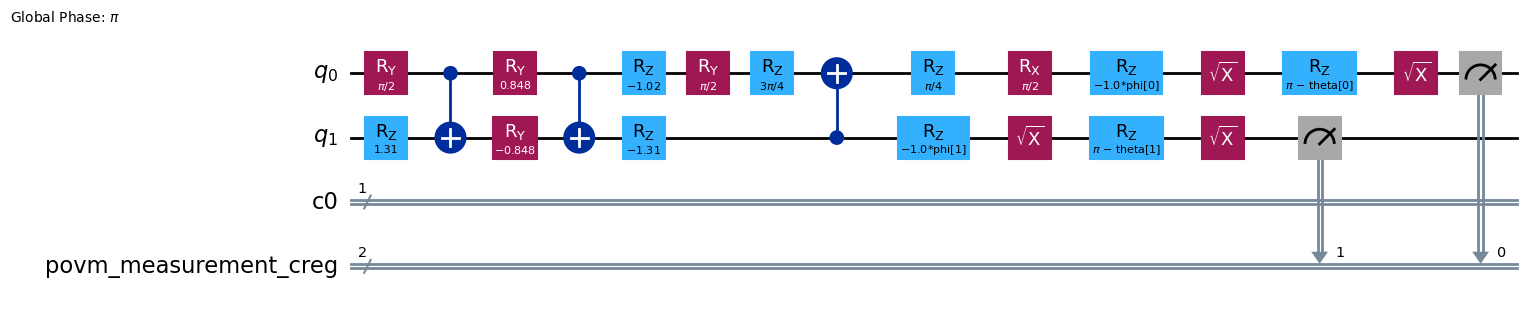

In [13]:
# Inspect one of the circuit sent to the internal `BaseSamplerV2` sampler:

lbcs_composed_circuit = result[1].metadata.composed_circuit
lbcs_composed_circuit.draw("mpl", style="iqp")